# Imaging and structure analysis of ferroelectric domains, domain walls, and vortices by scanning electron diffraction

Ursula Ludacka<sup>1</sup>, Jiali He<sup>1</sup>, Shuyu Qin<sup>3,4</sup>, Manuel Zahn<sup>1,5</sup>, Emil Frang Christiansen<sup>2</sup>, Kasper A. Hunnestad<sup>1</sup>, Zewu Yan<sup>6,7</sup>, Edith Bourret<sup>7</sup>, István Kézsmárki<sup>5</sup>, Antonius T. J. van Helvoort<sup>2</sup>, Joshua Agar<sup>3,4</sup>, Dennis Meier<sup>1</sup>

Email: dennis.meier@ntnu.no, jca92@drexel.edu

<sup>1</sup> Department of Materials Science and Engineering, NTNU Norwegian University of Science and Technology, Trondheim, Norway \
<sup>2</sup> Department of Physics, NTNU Norwegian University of Science and Technology, Trondheim, Norway\
<sup>3</sup> Department of Materials Science and Engineering, Lehigh University, Bethlehem, USA\
<sup>4</sup> Department of Mechanical Engineering and Mechanics, Drexel University, Philadelphia, USA\
<sup>5</sup> Experimental Physics V, University of Augsburg, Augsburg, Germany\
<sup>6</sup> Department of Physics, ETH Zurich, Zürich, Switzerland.\
<sup>7</sup> Materials Sciences Division, Lawrence Berkeley National Laboratory, Berkeley, USA.


## Abstract

Direct electron detectors in scanning transmission electron microscopy give unprecedented possibilities for structure analysis at the nanoscale. In electronic and quantum materials, this new capability gives access to, for example, emergent chiral structures and symmetry-breaking distortions that underpin functional properties. Quantifying nanoscale structural features with statistical significance, however, is complicated by the subtleties of dynamic diffraction and coexisting contrast mechanisms, which often results in low signal-to-noise and the superposition of multiple signals that are challenging to deconvolute. Here we apply scanning electron diffraction to explore local polar distortions in the uniaxial ferroelectric Er(Mn,Ti)O3. Using a custom-designed convolutional autoencoder with bespoke regularization, we demonstrate that subtle variations in the scattering signatures of ferroelectric domains, domain walls, and vortex textures can readily be disentangled with statistical significance and separated from extrinsic contributions due to, e.g., variations in specimen thickness or bending. The work demonstrates a pathway to quantitatively measure symmetry-breaking distortions across large areas, mapping structural changes at interfaces and topological structures with nanoscale spatial resolution.


$$L = \frac{\lambda}{2N} \sum\limits_{i=1}^{N} \left[\left(\sum\limits_{j=1, j\neq i}^{N} \frac{latent_i \cdot latent_j}{\left\lVert latent_i \right\rVert \left\lVert latent_j \right\rVert}\right] - 1\right)$$


## Imports and settings

In [1]:
%load_ext autoreload
%autoreload 2

In [2]:
import sys

sys.path.append("../../")
sys.path.append("/home/ferroelectric/m3_learning/m3_learning/src")


In [3]:
import matplotlib.pyplot as plt
import numpy as np
import hyperspy.api as hs
import torch

from m3_learning.nn.random import random_seed
from m3_learning.nn.STEM_AE.Viz import Viz
from m3_learning.nn.STEM_AE.STEM_AE import ConvAutoencoder
from m3_learning.viz.style import set_style
from m3_learning.viz.printing import printer
from m3_learning.viz.layout import layout_fig, imagemap, labelfigs, scalebar
from m3_learning.viz.Movies import make_movie
from m3_learning.nn.STEM_AE.Dataset import STEM_Dataset
printing = printer(basepath='./figures/')


set_style("printing")
random_seed(seed=42)

%matplotlib inline


printing set for seaborn
Pytorch seed was set to 42
Numpy seed was set to 42


2023-04-10 10:46:21.523194: I tensorflow/core/platform/cpu_feature_guard.cc:193] This TensorFlow binary is optimized with oneAPI Deep Neural Network Library (oneDNN) to use the following CPU instructions in performance-critical operations:  AVX2 FMA
To enable them in other operations, rebuild TensorFlow with the appropriate compiler flags.
2023-04-10 10:46:21.636493: E tensorflow/stream_executor/cuda/cuda_blas.cc:2981] Unable to register cuBLAS factory: Attempting to register factory for plugin cuBLAS when one has already been registered
2023-04-10 10:46:22.097577: W tensorflow/stream_executor/platform/default/dso_loader.cc:64] Could not load dynamic library 'libnvinfer.so.7'; dlerror: libnvinfer.so.7: cannot open shared object file: No such file or directory; LD_LIBRARY_PATH: /home/ferroelectric/anaconda3/envs/STEM/lib/python3.9/site-packages/cv2/../../lib64:
2023-04-10 10:46:22.097626: W tensorflow/stream_executor/platform/default/dso_loader.cc:64] Could not load dynamic library 'lib

tensorflow seed was set to 42


TODO: add download


## Loads the Dataset

In [4]:
# loads the dataset
# this object will also compute the log of the dataset
# this is available as self.log_data
domain = STEM_Dataset(data_path="/home/ferroelectric/data/256p_3w_step1k4_a5_cl12_50ms_nmf_4.hspy")

/home/ferroelectric/anaconda3/envs/STEM/lib/python3.9/site-packages/hyperspy/misc/utils.py:471: VisibleDeprecationWarning: Use of the `binned` attribute in metadata is going to be deprecated in v2.0. Set the `axis.is_binned` attribute instead. 
  warnings.warn(
/home/ferroelectric/anaconda3/envs/STEM/lib/python3.9/site-packages/hyperspy/io.py:572: VisibleDeprecationWarning: Loading old file version. The binned attribute has been moved from metadata.Signal to axis.is_binned. Setting this attribute for all signal axes instead.
  warnings.warn('Loading old file version. The binned attribute '


## Instantiates the Visualizer

In [5]:
# instantiates the visualization class
viz = Viz(printer = printing, labelfigs_=True)

## Visualizes the Raw Data

./figures/STEM_raw_and_virtual_domain.png
./figures/STEM_raw_and_virtual_domain.svg


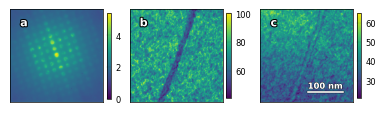

In [6]:
bright_field_ = (117,135, 119, 135)
dark_field_ = (102,117, 114,130)
printer_ = printer(basepath="./figures/")
filename = "STEM_raw_and_virtual_domain"
viz.scalebar_ = {'width': 250, 'scale length': 100, 'units': 'nm'}
viz.STEM_raw_and_virtual(domain, bright_field_=bright_field_, dark_field_=dark_field_, scalebar_=True, filename=filename, shape_ = domain.data.shape)

## Builds the Neural Network Model

In [7]:
encoder_step_size = [256, 256]
pooling_list = [4, 4, 2]
decoder_step_size = [8, 8]
upsampling_list = [2, 4, 4]
embedding_size = 32
conv_size = 128

# set device to load model
device = 'cpu'
if torch.cuda.is_available():
    device = 'cuda:1'

model = ConvAutoencoder(encoder_step_size=encoder_step_size,
                        pooling_list=pooling_list,
                        decoder_step_size=decoder_step_size,
                        upsampling_list=upsampling_list,
                        embedding_size=embedding_size,
                        conv_size=conv_size,
                        device=device,
                        learning_rate=3e-5)

## Trains or Loads Pretrained Weights

In [8]:
# set retrain parameter
train = False

if train:
    model.Train(domain.log_data,
          coef_1=1e-5,
          epochs=225,
          with_scheduler=False,
          folder_path="Domain_Weights",
          batch_size=256)
else:
    model.load_weights("/home/ferroelectric/data/11.23_log_epoch_0376_coef_1e-05_trainloss_0.1362.pkl")

## Computes the Embeddings

In [9]:
embedding = model.get_embedding(domain.log_data)


100%|██████████| 2048/2048 [04:07<00:00,  8.29it/s]


## Visualizes the Embeddings

./figures/domain wall_embedding_maps.png
./figures/domain wall_embedding_maps.svg


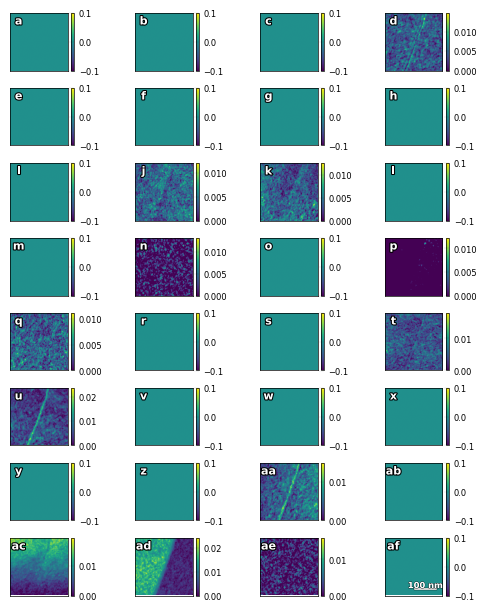

In [10]:
viz.model = model
viz.channels = [20,29]
viz.scalebar_ = {'width': 250, 'scale length': 100, 'units': 'nm'}
viz.embeddings(mod = 4, scalebar_=True, figsize = (5, 6), name = "domain wall", shape_=domain.data.shape)

## Generates Data from the Latent Space

In [11]:
model.embedding = embedding

ranges=[[0,0.018],[0,0.022]]
folder_name = 'Generator_of_Figure_4_a_d'

viz.generator_images(ranges = ranges, folder_name = folder_name, figsize=(3, 1.25), cbar_number_format = "%d", shape_=domain.data.shape)

  0%|          | 0/200 [00:00<?, ?it/s]

./figures/generator_images_Generator_of_Figure_4_a_d/0000_maps.png
./figures/generator_images_Generator_of_Figure_4_a_d/0000_maps.svg


  0%|          | 1/200 [00:01<03:27,  1.04s/it]

./figures/generator_images_Generator_of_Figure_4_a_d/0001_maps.png
./figures/generator_images_Generator_of_Figure_4_a_d/0001_maps.svg


  1%|          | 2/200 [00:02<03:25,  1.04s/it]

./figures/generator_images_Generator_of_Figure_4_a_d/0002_maps.png
./figures/generator_images_Generator_of_Figure_4_a_d/0002_maps.svg


  2%|▏         | 3/200 [00:03<03:24,  1.04s/it]

./figures/generator_images_Generator_of_Figure_4_a_d/0003_maps.png
./figures/generator_images_Generator_of_Figure_4_a_d/0003_maps.svg


  2%|▏         | 4/200 [00:04<03:23,  1.04s/it]

./figures/generator_images_Generator_of_Figure_4_a_d/0004_maps.png
./figures/generator_images_Generator_of_Figure_4_a_d/0004_maps.svg


  2%|▎         | 5/200 [00:05<03:22,  1.04s/it]

./figures/generator_images_Generator_of_Figure_4_a_d/0005_maps.png
./figures/generator_images_Generator_of_Figure_4_a_d/0005_maps.svg


  3%|▎         | 6/200 [00:06<03:20,  1.04s/it]

./figures/generator_images_Generator_of_Figure_4_a_d/0006_maps.png
./figures/generator_images_Generator_of_Figure_4_a_d/0006_maps.svg


  4%|▎         | 7/200 [00:07<03:19,  1.03s/it]

./figures/generator_images_Generator_of_Figure_4_a_d/0007_maps.png
./figures/generator_images_Generator_of_Figure_4_a_d/0007_maps.svg


  4%|▍         | 8/200 [00:08<03:18,  1.03s/it]

./figures/generator_images_Generator_of_Figure_4_a_d/0008_maps.png
./figures/generator_images_Generator_of_Figure_4_a_d/0008_maps.svg


  4%|▍         | 9/200 [00:09<03:17,  1.03s/it]

./figures/generator_images_Generator_of_Figure_4_a_d/0009_maps.png
./figures/generator_images_Generator_of_Figure_4_a_d/0009_maps.svg


  5%|▌         | 10/200 [00:10<03:16,  1.04s/it]

./figures/generator_images_Generator_of_Figure_4_a_d/0010_maps.png
./figures/generator_images_Generator_of_Figure_4_a_d/0010_maps.svg


  6%|▌         | 11/200 [00:11<03:31,  1.12s/it]

./figures/generator_images_Generator_of_Figure_4_a_d/0011_maps.png
./figures/generator_images_Generator_of_Figure_4_a_d/0011_maps.svg


  6%|▌         | 12/200 [00:12<03:25,  1.10s/it]

./figures/generator_images_Generator_of_Figure_4_a_d/0012_maps.png
./figures/generator_images_Generator_of_Figure_4_a_d/0012_maps.svg


  6%|▋         | 13/200 [00:13<03:21,  1.08s/it]

./figures/generator_images_Generator_of_Figure_4_a_d/0013_maps.png
./figures/generator_images_Generator_of_Figure_4_a_d/0013_maps.svg


  7%|▋         | 14/200 [00:14<03:18,  1.07s/it]

./figures/generator_images_Generator_of_Figure_4_a_d/0014_maps.png
./figures/generator_images_Generator_of_Figure_4_a_d/0014_maps.svg


  8%|▊         | 15/200 [00:15<03:16,  1.06s/it]

./figures/generator_images_Generator_of_Figure_4_a_d/0015_maps.png
./figures/generator_images_Generator_of_Figure_4_a_d/0015_maps.svg


  8%|▊         | 16/200 [00:16<03:13,  1.05s/it]

./figures/generator_images_Generator_of_Figure_4_a_d/0016_maps.png
./figures/generator_images_Generator_of_Figure_4_a_d/0016_maps.svg


  8%|▊         | 17/200 [00:17<03:11,  1.05s/it]

./figures/generator_images_Generator_of_Figure_4_a_d/0017_maps.png
./figures/generator_images_Generator_of_Figure_4_a_d/0017_maps.svg


  9%|▉         | 18/200 [00:18<03:10,  1.05s/it]

./figures/generator_images_Generator_of_Figure_4_a_d/0018_maps.png
./figures/generator_images_Generator_of_Figure_4_a_d/0018_maps.svg


 10%|▉         | 19/200 [00:19<03:08,  1.04s/it]

./figures/generator_images_Generator_of_Figure_4_a_d/0019_maps.png
./figures/generator_images_Generator_of_Figure_4_a_d/0019_maps.svg


 10%|█         | 20/200 [00:21<03:07,  1.04s/it]

./figures/generator_images_Generator_of_Figure_4_a_d/0020_maps.png
./figures/generator_images_Generator_of_Figure_4_a_d/0020_maps.svg


 10%|█         | 21/200 [00:22<03:06,  1.04s/it]

./figures/generator_images_Generator_of_Figure_4_a_d/0021_maps.png
./figures/generator_images_Generator_of_Figure_4_a_d/0021_maps.svg


 11%|█         | 22/200 [00:23<03:16,  1.10s/it]

./figures/generator_images_Generator_of_Figure_4_a_d/0022_maps.png
./figures/generator_images_Generator_of_Figure_4_a_d/0022_maps.svg


 12%|█▏        | 23/200 [00:24<03:11,  1.08s/it]

./figures/generator_images_Generator_of_Figure_4_a_d/0023_maps.png
./figures/generator_images_Generator_of_Figure_4_a_d/0023_maps.svg


 12%|█▏        | 24/200 [00:25<03:07,  1.06s/it]

./figures/generator_images_Generator_of_Figure_4_a_d/0024_maps.png
./figures/generator_images_Generator_of_Figure_4_a_d/0024_maps.svg


 12%|█▎        | 25/200 [00:26<03:04,  1.05s/it]

./figures/generator_images_Generator_of_Figure_4_a_d/0025_maps.png
./figures/generator_images_Generator_of_Figure_4_a_d/0025_maps.svg


 13%|█▎        | 26/200 [00:27<03:02,  1.05s/it]

./figures/generator_images_Generator_of_Figure_4_a_d/0026_maps.png
./figures/generator_images_Generator_of_Figure_4_a_d/0026_maps.svg


 14%|█▎        | 27/200 [00:28<03:00,  1.04s/it]

./figures/generator_images_Generator_of_Figure_4_a_d/0027_maps.png
./figures/generator_images_Generator_of_Figure_4_a_d/0027_maps.svg


 14%|█▍        | 28/200 [00:29<02:59,  1.04s/it]

./figures/generator_images_Generator_of_Figure_4_a_d/0028_maps.png
./figures/generator_images_Generator_of_Figure_4_a_d/0028_maps.svg


 14%|█▍        | 29/200 [00:30<02:57,  1.04s/it]

./figures/generator_images_Generator_of_Figure_4_a_d/0029_maps.png
./figures/generator_images_Generator_of_Figure_4_a_d/0029_maps.svg


 15%|█▌        | 30/200 [00:31<02:56,  1.04s/it]

./figures/generator_images_Generator_of_Figure_4_a_d/0030_maps.png
./figures/generator_images_Generator_of_Figure_4_a_d/0030_maps.svg


 16%|█▌        | 31/200 [00:32<02:54,  1.03s/it]

./figures/generator_images_Generator_of_Figure_4_a_d/0031_maps.png
./figures/generator_images_Generator_of_Figure_4_a_d/0031_maps.svg


 16%|█▌        | 32/200 [00:33<02:53,  1.03s/it]

./figures/generator_images_Generator_of_Figure_4_a_d/0032_maps.png
./figures/generator_images_Generator_of_Figure_4_a_d/0032_maps.svg


 16%|█▋        | 33/200 [00:34<02:53,  1.04s/it]

./figures/generator_images_Generator_of_Figure_4_a_d/0033_maps.png
./figures/generator_images_Generator_of_Figure_4_a_d/0033_maps.svg


 17%|█▋        | 34/200 [00:35<02:52,  1.04s/it]

./figures/generator_images_Generator_of_Figure_4_a_d/0034_maps.png
./figures/generator_images_Generator_of_Figure_4_a_d/0034_maps.svg


 18%|█▊        | 35/200 [00:36<02:51,  1.04s/it]

./figures/generator_images_Generator_of_Figure_4_a_d/0035_maps.png
./figures/generator_images_Generator_of_Figure_4_a_d/0035_maps.svg


 18%|█▊        | 36/200 [00:37<02:49,  1.04s/it]

./figures/generator_images_Generator_of_Figure_4_a_d/0036_maps.png
./figures/generator_images_Generator_of_Figure_4_a_d/0036_maps.svg


 18%|█▊        | 37/200 [00:39<03:01,  1.12s/it]

./figures/generator_images_Generator_of_Figure_4_a_d/0037_maps.png
./figures/generator_images_Generator_of_Figure_4_a_d/0037_maps.svg


 19%|█▉        | 38/200 [00:40<02:56,  1.09s/it]

./figures/generator_images_Generator_of_Figure_4_a_d/0038_maps.png
./figures/generator_images_Generator_of_Figure_4_a_d/0038_maps.svg


 20%|█▉        | 39/200 [00:41<02:52,  1.07s/it]

./figures/generator_images_Generator_of_Figure_4_a_d/0039_maps.png
./figures/generator_images_Generator_of_Figure_4_a_d/0039_maps.svg


 20%|██        | 40/200 [00:42<02:49,  1.06s/it]

./figures/generator_images_Generator_of_Figure_4_a_d/0040_maps.png
./figures/generator_images_Generator_of_Figure_4_a_d/0040_maps.svg


 20%|██        | 41/200 [00:43<02:47,  1.05s/it]

./figures/generator_images_Generator_of_Figure_4_a_d/0041_maps.png
./figures/generator_images_Generator_of_Figure_4_a_d/0041_maps.svg


 21%|██        | 42/200 [00:44<02:45,  1.05s/it]

./figures/generator_images_Generator_of_Figure_4_a_d/0042_maps.png
./figures/generator_images_Generator_of_Figure_4_a_d/0042_maps.svg


 22%|██▏       | 43/200 [00:45<02:44,  1.04s/it]

./figures/generator_images_Generator_of_Figure_4_a_d/0043_maps.png
./figures/generator_images_Generator_of_Figure_4_a_d/0043_maps.svg


 22%|██▏       | 44/200 [00:46<02:42,  1.04s/it]

./figures/generator_images_Generator_of_Figure_4_a_d/0044_maps.png
./figures/generator_images_Generator_of_Figure_4_a_d/0044_maps.svg


 22%|██▎       | 45/200 [00:47<02:40,  1.04s/it]

./figures/generator_images_Generator_of_Figure_4_a_d/0045_maps.png
./figures/generator_images_Generator_of_Figure_4_a_d/0045_maps.svg


 23%|██▎       | 46/200 [00:48<02:39,  1.03s/it]

./figures/generator_images_Generator_of_Figure_4_a_d/0046_maps.png
./figures/generator_images_Generator_of_Figure_4_a_d/0046_maps.svg


 24%|██▎       | 47/200 [00:49<02:37,  1.03s/it]

./figures/generator_images_Generator_of_Figure_4_a_d/0047_maps.png
./figures/generator_images_Generator_of_Figure_4_a_d/0047_maps.svg


 24%|██▍       | 48/200 [00:50<02:36,  1.03s/it]

./figures/generator_images_Generator_of_Figure_4_a_d/0048_maps.png
./figures/generator_images_Generator_of_Figure_4_a_d/0048_maps.svg


 24%|██▍       | 49/200 [00:51<02:35,  1.03s/it]

./figures/generator_images_Generator_of_Figure_4_a_d/0049_maps.png
./figures/generator_images_Generator_of_Figure_4_a_d/0049_maps.svg


 25%|██▌       | 50/200 [00:52<02:34,  1.03s/it]

./figures/generator_images_Generator_of_Figure_4_a_d/0050_maps.png
./figures/generator_images_Generator_of_Figure_4_a_d/0050_maps.svg


 26%|██▌       | 51/200 [00:53<02:33,  1.03s/it]

./figures/generator_images_Generator_of_Figure_4_a_d/0051_maps.png
./figures/generator_images_Generator_of_Figure_4_a_d/0051_maps.svg


 26%|██▌       | 52/200 [00:54<02:32,  1.03s/it]

./figures/generator_images_Generator_of_Figure_4_a_d/0052_maps.png
./figures/generator_images_Generator_of_Figure_4_a_d/0052_maps.svg


 26%|██▋       | 53/200 [00:55<02:31,  1.03s/it]

./figures/generator_images_Generator_of_Figure_4_a_d/0053_maps.png
./figures/generator_images_Generator_of_Figure_4_a_d/0053_maps.svg


 27%|██▋       | 54/200 [00:56<02:30,  1.03s/it]

./figures/generator_images_Generator_of_Figure_4_a_d/0054_maps.png
./figures/generator_images_Generator_of_Figure_4_a_d/0054_maps.svg


 28%|██▊       | 55/200 [00:57<02:43,  1.13s/it]

./figures/generator_images_Generator_of_Figure_4_a_d/0055_maps.png
./figures/generator_images_Generator_of_Figure_4_a_d/0055_maps.svg


 28%|██▊       | 56/200 [00:58<02:38,  1.10s/it]

./figures/generator_images_Generator_of_Figure_4_a_d/0056_maps.png
./figures/generator_images_Generator_of_Figure_4_a_d/0056_maps.svg


 28%|██▊       | 57/200 [01:00<02:34,  1.08s/it]

./figures/generator_images_Generator_of_Figure_4_a_d/0057_maps.png
./figures/generator_images_Generator_of_Figure_4_a_d/0057_maps.svg


 29%|██▉       | 58/200 [01:01<02:30,  1.06s/it]

./figures/generator_images_Generator_of_Figure_4_a_d/0058_maps.png
./figures/generator_images_Generator_of_Figure_4_a_d/0058_maps.svg


 30%|██▉       | 59/200 [01:02<02:28,  1.05s/it]

./figures/generator_images_Generator_of_Figure_4_a_d/0059_maps.png
./figures/generator_images_Generator_of_Figure_4_a_d/0059_maps.svg


 30%|███       | 60/200 [01:03<02:26,  1.04s/it]

./figures/generator_images_Generator_of_Figure_4_a_d/0060_maps.png
./figures/generator_images_Generator_of_Figure_4_a_d/0060_maps.svg


 30%|███       | 61/200 [01:04<02:24,  1.04s/it]

./figures/generator_images_Generator_of_Figure_4_a_d/0061_maps.png
./figures/generator_images_Generator_of_Figure_4_a_d/0061_maps.svg


 31%|███       | 62/200 [01:05<02:22,  1.03s/it]

./figures/generator_images_Generator_of_Figure_4_a_d/0062_maps.png
./figures/generator_images_Generator_of_Figure_4_a_d/0062_maps.svg


 32%|███▏      | 63/200 [01:06<02:21,  1.03s/it]

./figures/generator_images_Generator_of_Figure_4_a_d/0063_maps.png
./figures/generator_images_Generator_of_Figure_4_a_d/0063_maps.svg


 32%|███▏      | 64/200 [01:07<02:20,  1.03s/it]

./figures/generator_images_Generator_of_Figure_4_a_d/0064_maps.png
./figures/generator_images_Generator_of_Figure_4_a_d/0064_maps.svg


 32%|███▎      | 65/200 [01:08<02:18,  1.03s/it]

./figures/generator_images_Generator_of_Figure_4_a_d/0065_maps.png
./figures/generator_images_Generator_of_Figure_4_a_d/0065_maps.svg


 33%|███▎      | 66/200 [01:09<02:17,  1.03s/it]

./figures/generator_images_Generator_of_Figure_4_a_d/0066_maps.png
./figures/generator_images_Generator_of_Figure_4_a_d/0066_maps.svg


 34%|███▎      | 67/200 [01:10<02:16,  1.03s/it]

./figures/generator_images_Generator_of_Figure_4_a_d/0067_maps.png
./figures/generator_images_Generator_of_Figure_4_a_d/0067_maps.svg


 34%|███▍      | 68/200 [01:11<02:15,  1.03s/it]

./figures/generator_images_Generator_of_Figure_4_a_d/0068_maps.png
./figures/generator_images_Generator_of_Figure_4_a_d/0068_maps.svg


 34%|███▍      | 69/200 [01:12<02:14,  1.02s/it]

./figures/generator_images_Generator_of_Figure_4_a_d/0069_maps.png
./figures/generator_images_Generator_of_Figure_4_a_d/0069_maps.svg


 35%|███▌      | 70/200 [01:13<02:13,  1.02s/it]

./figures/generator_images_Generator_of_Figure_4_a_d/0070_maps.png
./figures/generator_images_Generator_of_Figure_4_a_d/0070_maps.svg


 36%|███▌      | 71/200 [01:14<02:11,  1.02s/it]

./figures/generator_images_Generator_of_Figure_4_a_d/0071_maps.png
./figures/generator_images_Generator_of_Figure_4_a_d/0071_maps.svg


 36%|███▌      | 72/200 [01:15<02:11,  1.02s/it]

./figures/generator_images_Generator_of_Figure_4_a_d/0072_maps.png
./figures/generator_images_Generator_of_Figure_4_a_d/0072_maps.svg


 36%|███▋      | 73/200 [01:16<02:09,  1.02s/it]

./figures/generator_images_Generator_of_Figure_4_a_d/0073_maps.png
./figures/generator_images_Generator_of_Figure_4_a_d/0073_maps.svg


 37%|███▋      | 74/200 [01:17<02:08,  1.02s/it]

./figures/generator_images_Generator_of_Figure_4_a_d/0074_maps.png
./figures/generator_images_Generator_of_Figure_4_a_d/0074_maps.svg


 38%|███▊      | 75/200 [01:18<02:07,  1.02s/it]

./figures/generator_images_Generator_of_Figure_4_a_d/0075_maps.png
./figures/generator_images_Generator_of_Figure_4_a_d/0075_maps.svg


 38%|███▊      | 76/200 [01:19<02:06,  1.02s/it]

./figures/generator_images_Generator_of_Figure_4_a_d/0076_maps.png
./figures/generator_images_Generator_of_Figure_4_a_d/0076_maps.svg


 38%|███▊      | 77/200 [01:20<02:05,  1.02s/it]

./figures/generator_images_Generator_of_Figure_4_a_d/0077_maps.png
./figures/generator_images_Generator_of_Figure_4_a_d/0077_maps.svg


 39%|███▉      | 78/200 [01:21<02:19,  1.14s/it]

./figures/generator_images_Generator_of_Figure_4_a_d/0078_maps.png
./figures/generator_images_Generator_of_Figure_4_a_d/0078_maps.svg


 40%|███▉      | 79/200 [01:22<02:14,  1.11s/it]

./figures/generator_images_Generator_of_Figure_4_a_d/0079_maps.png
./figures/generator_images_Generator_of_Figure_4_a_d/0079_maps.svg


 40%|████      | 80/200 [01:23<02:10,  1.08s/it]

./figures/generator_images_Generator_of_Figure_4_a_d/0080_maps.png
./figures/generator_images_Generator_of_Figure_4_a_d/0080_maps.svg


 40%|████      | 81/200 [01:24<02:07,  1.07s/it]

./figures/generator_images_Generator_of_Figure_4_a_d/0081_maps.png
./figures/generator_images_Generator_of_Figure_4_a_d/0081_maps.svg


 41%|████      | 82/200 [01:26<02:04,  1.05s/it]

./figures/generator_images_Generator_of_Figure_4_a_d/0082_maps.png
./figures/generator_images_Generator_of_Figure_4_a_d/0082_maps.svg


 42%|████▏     | 83/200 [01:27<02:02,  1.05s/it]

./figures/generator_images_Generator_of_Figure_4_a_d/0083_maps.png
./figures/generator_images_Generator_of_Figure_4_a_d/0083_maps.svg


 42%|████▏     | 84/200 [01:28<02:00,  1.04s/it]

./figures/generator_images_Generator_of_Figure_4_a_d/0084_maps.png
./figures/generator_images_Generator_of_Figure_4_a_d/0084_maps.svg


 42%|████▎     | 85/200 [01:29<01:59,  1.04s/it]

./figures/generator_images_Generator_of_Figure_4_a_d/0085_maps.png
./figures/generator_images_Generator_of_Figure_4_a_d/0085_maps.svg


 43%|████▎     | 86/200 [01:30<01:58,  1.04s/it]

./figures/generator_images_Generator_of_Figure_4_a_d/0086_maps.png
./figures/generator_images_Generator_of_Figure_4_a_d/0086_maps.svg


 44%|████▎     | 87/200 [01:31<01:57,  1.04s/it]

./figures/generator_images_Generator_of_Figure_4_a_d/0087_maps.png
./figures/generator_images_Generator_of_Figure_4_a_d/0087_maps.svg


 44%|████▍     | 88/200 [01:32<01:55,  1.03s/it]

./figures/generator_images_Generator_of_Figure_4_a_d/0088_maps.png
./figures/generator_images_Generator_of_Figure_4_a_d/0088_maps.svg


 44%|████▍     | 89/200 [01:33<01:54,  1.03s/it]

./figures/generator_images_Generator_of_Figure_4_a_d/0089_maps.png
./figures/generator_images_Generator_of_Figure_4_a_d/0089_maps.svg


 45%|████▌     | 90/200 [01:34<01:53,  1.03s/it]

./figures/generator_images_Generator_of_Figure_4_a_d/0090_maps.png
./figures/generator_images_Generator_of_Figure_4_a_d/0090_maps.svg


 46%|████▌     | 91/200 [01:35<01:52,  1.03s/it]

./figures/generator_images_Generator_of_Figure_4_a_d/0091_maps.png
./figures/generator_images_Generator_of_Figure_4_a_d/0091_maps.svg


 46%|████▌     | 92/200 [01:36<01:51,  1.03s/it]

./figures/generator_images_Generator_of_Figure_4_a_d/0092_maps.png
./figures/generator_images_Generator_of_Figure_4_a_d/0092_maps.svg


 46%|████▋     | 93/200 [01:37<01:50,  1.03s/it]

./figures/generator_images_Generator_of_Figure_4_a_d/0093_maps.png
./figures/generator_images_Generator_of_Figure_4_a_d/0093_maps.svg


 47%|████▋     | 94/200 [01:38<01:49,  1.03s/it]

./figures/generator_images_Generator_of_Figure_4_a_d/0094_maps.png
./figures/generator_images_Generator_of_Figure_4_a_d/0094_maps.svg


 48%|████▊     | 95/200 [01:39<01:48,  1.03s/it]

./figures/generator_images_Generator_of_Figure_4_a_d/0095_maps.png
./figures/generator_images_Generator_of_Figure_4_a_d/0095_maps.svg


 48%|████▊     | 96/200 [01:40<01:47,  1.03s/it]

./figures/generator_images_Generator_of_Figure_4_a_d/0096_maps.png
./figures/generator_images_Generator_of_Figure_4_a_d/0096_maps.svg


 48%|████▊     | 97/200 [01:41<01:46,  1.03s/it]

./figures/generator_images_Generator_of_Figure_4_a_d/0097_maps.png
./figures/generator_images_Generator_of_Figure_4_a_d/0097_maps.svg


 49%|████▉     | 98/200 [01:42<01:45,  1.03s/it]

./figures/generator_images_Generator_of_Figure_4_a_d/0098_maps.png
./figures/generator_images_Generator_of_Figure_4_a_d/0098_maps.svg


 50%|████▉     | 99/200 [01:43<01:43,  1.03s/it]

./figures/generator_images_Generator_of_Figure_4_a_d/0099_maps.png
./figures/generator_images_Generator_of_Figure_4_a_d/0099_maps.svg


 50%|█████     | 100/200 [01:44<01:42,  1.03s/it]

./figures/generator_images_Generator_of_Figure_4_a_d/0100_maps.png
./figures/generator_images_Generator_of_Figure_4_a_d/0100_maps.svg


 50%|█████     | 101/200 [01:45<01:41,  1.03s/it]

./figures/generator_images_Generator_of_Figure_4_a_d/0101_maps.png
./figures/generator_images_Generator_of_Figure_4_a_d/0101_maps.svg


 51%|█████     | 102/200 [01:46<01:40,  1.03s/it]

./figures/generator_images_Generator_of_Figure_4_a_d/0102_maps.png
./figures/generator_images_Generator_of_Figure_4_a_d/0102_maps.svg


 52%|█████▏    | 103/200 [01:47<01:39,  1.03s/it]

./figures/generator_images_Generator_of_Figure_4_a_d/0103_maps.png
./figures/generator_images_Generator_of_Figure_4_a_d/0103_maps.svg


 52%|█████▏    | 104/200 [01:48<01:38,  1.03s/it]

./figures/generator_images_Generator_of_Figure_4_a_d/0104_maps.png
./figures/generator_images_Generator_of_Figure_4_a_d/0104_maps.svg


 52%|█████▎    | 105/200 [01:49<01:37,  1.03s/it]

./figures/generator_images_Generator_of_Figure_4_a_d/0105_maps.png
./figures/generator_images_Generator_of_Figure_4_a_d/0105_maps.svg


 53%|█████▎    | 106/200 [01:51<01:50,  1.17s/it]

./figures/generator_images_Generator_of_Figure_4_a_d/0106_maps.png
./figures/generator_images_Generator_of_Figure_4_a_d/0106_maps.svg


 54%|█████▎    | 107/200 [01:52<01:45,  1.13s/it]

./figures/generator_images_Generator_of_Figure_4_a_d/0107_maps.png
./figures/generator_images_Generator_of_Figure_4_a_d/0107_maps.svg


 54%|█████▍    | 108/200 [01:53<01:41,  1.10s/it]

./figures/generator_images_Generator_of_Figure_4_a_d/0108_maps.png
./figures/generator_images_Generator_of_Figure_4_a_d/0108_maps.svg


 55%|█████▍    | 109/200 [01:54<01:37,  1.08s/it]

./figures/generator_images_Generator_of_Figure_4_a_d/0109_maps.png
./figures/generator_images_Generator_of_Figure_4_a_d/0109_maps.svg


 55%|█████▌    | 110/200 [01:55<01:35,  1.06s/it]

./figures/generator_images_Generator_of_Figure_4_a_d/0110_maps.png
./figures/generator_images_Generator_of_Figure_4_a_d/0110_maps.svg


 56%|█████▌    | 111/200 [01:56<01:33,  1.05s/it]

./figures/generator_images_Generator_of_Figure_4_a_d/0111_maps.png
./figures/generator_images_Generator_of_Figure_4_a_d/0111_maps.svg


 56%|█████▌    | 112/200 [01:57<01:31,  1.04s/it]

./figures/generator_images_Generator_of_Figure_4_a_d/0112_maps.png
./figures/generator_images_Generator_of_Figure_4_a_d/0112_maps.svg


 56%|█████▋    | 113/200 [01:58<01:30,  1.04s/it]

./figures/generator_images_Generator_of_Figure_4_a_d/0113_maps.png
./figures/generator_images_Generator_of_Figure_4_a_d/0113_maps.svg


 57%|█████▋    | 114/200 [01:59<01:28,  1.03s/it]

./figures/generator_images_Generator_of_Figure_4_a_d/0114_maps.png
./figures/generator_images_Generator_of_Figure_4_a_d/0114_maps.svg


 57%|█████▊    | 115/200 [02:00<01:28,  1.04s/it]

./figures/generator_images_Generator_of_Figure_4_a_d/0115_maps.png
./figures/generator_images_Generator_of_Figure_4_a_d/0115_maps.svg


 58%|█████▊    | 116/200 [02:01<01:27,  1.04s/it]

./figures/generator_images_Generator_of_Figure_4_a_d/0116_maps.png
./figures/generator_images_Generator_of_Figure_4_a_d/0116_maps.svg


 58%|█████▊    | 117/200 [02:02<01:26,  1.04s/it]

./figures/generator_images_Generator_of_Figure_4_a_d/0117_maps.png
./figures/generator_images_Generator_of_Figure_4_a_d/0117_maps.svg


 59%|█████▉    | 118/200 [02:03<01:25,  1.04s/it]

./figures/generator_images_Generator_of_Figure_4_a_d/0118_maps.png
./figures/generator_images_Generator_of_Figure_4_a_d/0118_maps.svg


 60%|█████▉    | 119/200 [02:04<01:24,  1.04s/it]

./figures/generator_images_Generator_of_Figure_4_a_d/0119_maps.png
./figures/generator_images_Generator_of_Figure_4_a_d/0119_maps.svg


 60%|██████    | 120/200 [02:05<01:23,  1.04s/it]

./figures/generator_images_Generator_of_Figure_4_a_d/0120_maps.png
./figures/generator_images_Generator_of_Figure_4_a_d/0120_maps.svg


 60%|██████    | 121/200 [02:06<01:22,  1.04s/it]

./figures/generator_images_Generator_of_Figure_4_a_d/0121_maps.png
./figures/generator_images_Generator_of_Figure_4_a_d/0121_maps.svg


 61%|██████    | 122/200 [02:07<01:21,  1.04s/it]

./figures/generator_images_Generator_of_Figure_4_a_d/0122_maps.png
./figures/generator_images_Generator_of_Figure_4_a_d/0122_maps.svg


 62%|██████▏   | 123/200 [02:08<01:19,  1.04s/it]

./figures/generator_images_Generator_of_Figure_4_a_d/0123_maps.png
./figures/generator_images_Generator_of_Figure_4_a_d/0123_maps.svg


 62%|██████▏   | 124/200 [02:09<01:18,  1.04s/it]

./figures/generator_images_Generator_of_Figure_4_a_d/0124_maps.png
./figures/generator_images_Generator_of_Figure_4_a_d/0124_maps.svg


 62%|██████▎   | 125/200 [02:10<01:17,  1.03s/it]

./figures/generator_images_Generator_of_Figure_4_a_d/0125_maps.png
./figures/generator_images_Generator_of_Figure_4_a_d/0125_maps.svg


 63%|██████▎   | 126/200 [02:11<01:17,  1.05s/it]

./figures/generator_images_Generator_of_Figure_4_a_d/0126_maps.png
./figures/generator_images_Generator_of_Figure_4_a_d/0126_maps.svg


 64%|██████▎   | 127/200 [02:12<01:16,  1.04s/it]

./figures/generator_images_Generator_of_Figure_4_a_d/0127_maps.png
./figures/generator_images_Generator_of_Figure_4_a_d/0127_maps.svg


 64%|██████▍   | 128/200 [02:14<01:14,  1.04s/it]

./figures/generator_images_Generator_of_Figure_4_a_d/0128_maps.png
./figures/generator_images_Generator_of_Figure_4_a_d/0128_maps.svg


 64%|██████▍   | 129/200 [02:15<01:13,  1.04s/it]

./figures/generator_images_Generator_of_Figure_4_a_d/0129_maps.png
./figures/generator_images_Generator_of_Figure_4_a_d/0129_maps.svg


 65%|██████▌   | 130/200 [02:16<01:12,  1.04s/it]

./figures/generator_images_Generator_of_Figure_4_a_d/0130_maps.png
./figures/generator_images_Generator_of_Figure_4_a_d/0130_maps.svg


 66%|██████▌   | 131/200 [02:17<01:11,  1.04s/it]

./figures/generator_images_Generator_of_Figure_4_a_d/0131_maps.png
./figures/generator_images_Generator_of_Figure_4_a_d/0131_maps.svg


 66%|██████▌   | 132/200 [02:18<01:10,  1.04s/it]

./figures/generator_images_Generator_of_Figure_4_a_d/0132_maps.png
./figures/generator_images_Generator_of_Figure_4_a_d/0132_maps.svg


 66%|██████▋   | 133/200 [02:19<01:09,  1.04s/it]

./figures/generator_images_Generator_of_Figure_4_a_d/0133_maps.png
./figures/generator_images_Generator_of_Figure_4_a_d/0133_maps.svg


 67%|██████▋   | 134/200 [02:20<01:08,  1.04s/it]

./figures/generator_images_Generator_of_Figure_4_a_d/0134_maps.png
./figures/generator_images_Generator_of_Figure_4_a_d/0134_maps.svg


 68%|██████▊   | 135/200 [02:21<01:07,  1.05s/it]

./figures/generator_images_Generator_of_Figure_4_a_d/0135_maps.png
./figures/generator_images_Generator_of_Figure_4_a_d/0135_maps.svg


 68%|██████▊   | 136/200 [02:22<01:07,  1.05s/it]

./figures/generator_images_Generator_of_Figure_4_a_d/0136_maps.png
./figures/generator_images_Generator_of_Figure_4_a_d/0136_maps.svg


 68%|██████▊   | 137/200 [02:23<01:06,  1.05s/it]

./figures/generator_images_Generator_of_Figure_4_a_d/0137_maps.png
./figures/generator_images_Generator_of_Figure_4_a_d/0137_maps.svg


 69%|██████▉   | 138/200 [02:24<01:04,  1.05s/it]

./figures/generator_images_Generator_of_Figure_4_a_d/0138_maps.png
./figures/generator_images_Generator_of_Figure_4_a_d/0138_maps.svg


 70%|██████▉   | 139/200 [02:25<01:03,  1.05s/it]

./figures/generator_images_Generator_of_Figure_4_a_d/0139_maps.png
./figures/generator_images_Generator_of_Figure_4_a_d/0139_maps.svg


 70%|███████   | 140/200 [02:26<01:02,  1.05s/it]

./figures/generator_images_Generator_of_Figure_4_a_d/0140_maps.png
./figures/generator_images_Generator_of_Figure_4_a_d/0140_maps.svg


 70%|███████   | 141/200 [02:28<01:12,  1.23s/it]

./figures/generator_images_Generator_of_Figure_4_a_d/0141_maps.png
./figures/generator_images_Generator_of_Figure_4_a_d/0141_maps.svg


 71%|███████   | 142/200 [02:29<01:08,  1.17s/it]

./figures/generator_images_Generator_of_Figure_4_a_d/0142_maps.png
./figures/generator_images_Generator_of_Figure_4_a_d/0142_maps.svg


 72%|███████▏  | 143/200 [02:30<01:04,  1.13s/it]

./figures/generator_images_Generator_of_Figure_4_a_d/0143_maps.png
./figures/generator_images_Generator_of_Figure_4_a_d/0143_maps.svg


 72%|███████▏  | 144/200 [02:31<01:01,  1.10s/it]

./figures/generator_images_Generator_of_Figure_4_a_d/0144_maps.png
./figures/generator_images_Generator_of_Figure_4_a_d/0144_maps.svg


 72%|███████▎  | 145/200 [02:32<00:59,  1.08s/it]

./figures/generator_images_Generator_of_Figure_4_a_d/0145_maps.png
./figures/generator_images_Generator_of_Figure_4_a_d/0145_maps.svg


 73%|███████▎  | 146/200 [02:33<00:57,  1.07s/it]

./figures/generator_images_Generator_of_Figure_4_a_d/0146_maps.png
./figures/generator_images_Generator_of_Figure_4_a_d/0146_maps.svg


 74%|███████▎  | 147/200 [02:34<00:56,  1.06s/it]

./figures/generator_images_Generator_of_Figure_4_a_d/0147_maps.png
./figures/generator_images_Generator_of_Figure_4_a_d/0147_maps.svg


 74%|███████▍  | 148/200 [02:35<00:54,  1.05s/it]

./figures/generator_images_Generator_of_Figure_4_a_d/0148_maps.png
./figures/generator_images_Generator_of_Figure_4_a_d/0148_maps.svg


 74%|███████▍  | 149/200 [02:36<00:53,  1.05s/it]

./figures/generator_images_Generator_of_Figure_4_a_d/0149_maps.png
./figures/generator_images_Generator_of_Figure_4_a_d/0149_maps.svg


 75%|███████▌  | 150/200 [02:37<00:52,  1.04s/it]

./figures/generator_images_Generator_of_Figure_4_a_d/0150_maps.png
./figures/generator_images_Generator_of_Figure_4_a_d/0150_maps.svg


 76%|███████▌  | 151/200 [02:38<00:50,  1.04s/it]

./figures/generator_images_Generator_of_Figure_4_a_d/0151_maps.png
./figures/generator_images_Generator_of_Figure_4_a_d/0151_maps.svg


 76%|███████▌  | 152/200 [02:39<00:49,  1.04s/it]

./figures/generator_images_Generator_of_Figure_4_a_d/0152_maps.png
./figures/generator_images_Generator_of_Figure_4_a_d/0152_maps.svg


 76%|███████▋  | 153/200 [02:40<00:48,  1.03s/it]

./figures/generator_images_Generator_of_Figure_4_a_d/0153_maps.png
./figures/generator_images_Generator_of_Figure_4_a_d/0153_maps.svg


 77%|███████▋  | 154/200 [02:41<00:47,  1.03s/it]

./figures/generator_images_Generator_of_Figure_4_a_d/0154_maps.png
./figures/generator_images_Generator_of_Figure_4_a_d/0154_maps.svg


 78%|███████▊  | 155/200 [02:42<00:46,  1.03s/it]

./figures/generator_images_Generator_of_Figure_4_a_d/0155_maps.png
./figures/generator_images_Generator_of_Figure_4_a_d/0155_maps.svg


 78%|███████▊  | 156/200 [02:43<00:45,  1.03s/it]

./figures/generator_images_Generator_of_Figure_4_a_d/0156_maps.png
./figures/generator_images_Generator_of_Figure_4_a_d/0156_maps.svg


 78%|███████▊  | 157/200 [02:44<00:44,  1.03s/it]

./figures/generator_images_Generator_of_Figure_4_a_d/0157_maps.png
./figures/generator_images_Generator_of_Figure_4_a_d/0157_maps.svg


 79%|███████▉  | 158/200 [02:45<00:43,  1.03s/it]

./figures/generator_images_Generator_of_Figure_4_a_d/0158_maps.png
./figures/generator_images_Generator_of_Figure_4_a_d/0158_maps.svg


 80%|███████▉  | 159/200 [02:46<00:42,  1.03s/it]

./figures/generator_images_Generator_of_Figure_4_a_d/0159_maps.png
./figures/generator_images_Generator_of_Figure_4_a_d/0159_maps.svg


 80%|████████  | 160/200 [02:47<00:41,  1.03s/it]

./figures/generator_images_Generator_of_Figure_4_a_d/0160_maps.png
./figures/generator_images_Generator_of_Figure_4_a_d/0160_maps.svg


 80%|████████  | 161/200 [02:48<00:40,  1.03s/it]

./figures/generator_images_Generator_of_Figure_4_a_d/0161_maps.png
./figures/generator_images_Generator_of_Figure_4_a_d/0161_maps.svg


 81%|████████  | 162/200 [02:49<00:39,  1.03s/it]

./figures/generator_images_Generator_of_Figure_4_a_d/0162_maps.png
./figures/generator_images_Generator_of_Figure_4_a_d/0162_maps.svg


 82%|████████▏ | 163/200 [02:50<00:38,  1.04s/it]

./figures/generator_images_Generator_of_Figure_4_a_d/0163_maps.png
./figures/generator_images_Generator_of_Figure_4_a_d/0163_maps.svg


 82%|████████▏ | 164/200 [02:51<00:37,  1.04s/it]

./figures/generator_images_Generator_of_Figure_4_a_d/0164_maps.png
./figures/generator_images_Generator_of_Figure_4_a_d/0164_maps.svg


 82%|████████▎ | 165/200 [02:53<00:36,  1.04s/it]

./figures/generator_images_Generator_of_Figure_4_a_d/0165_maps.png
./figures/generator_images_Generator_of_Figure_4_a_d/0165_maps.svg


 83%|████████▎ | 166/200 [02:54<00:35,  1.04s/it]

./figures/generator_images_Generator_of_Figure_4_a_d/0166_maps.png
./figures/generator_images_Generator_of_Figure_4_a_d/0166_maps.svg


 84%|████████▎ | 167/200 [02:55<00:34,  1.04s/it]

./figures/generator_images_Generator_of_Figure_4_a_d/0167_maps.png
./figures/generator_images_Generator_of_Figure_4_a_d/0167_maps.svg


 84%|████████▍ | 168/200 [02:56<00:33,  1.04s/it]

./figures/generator_images_Generator_of_Figure_4_a_d/0168_maps.png
./figures/generator_images_Generator_of_Figure_4_a_d/0168_maps.svg


 84%|████████▍ | 169/200 [02:57<00:32,  1.04s/it]

./figures/generator_images_Generator_of_Figure_4_a_d/0169_maps.png
./figures/generator_images_Generator_of_Figure_4_a_d/0169_maps.svg


 85%|████████▌ | 170/200 [02:58<00:31,  1.04s/it]

./figures/generator_images_Generator_of_Figure_4_a_d/0170_maps.png
./figures/generator_images_Generator_of_Figure_4_a_d/0170_maps.svg


 86%|████████▌ | 171/200 [02:59<00:30,  1.04s/it]

./figures/generator_images_Generator_of_Figure_4_a_d/0171_maps.png
./figures/generator_images_Generator_of_Figure_4_a_d/0171_maps.svg


 86%|████████▌ | 172/200 [03:00<00:29,  1.04s/it]

./figures/generator_images_Generator_of_Figure_4_a_d/0172_maps.png
./figures/generator_images_Generator_of_Figure_4_a_d/0172_maps.svg


 86%|████████▋ | 173/200 [03:01<00:27,  1.03s/it]

./figures/generator_images_Generator_of_Figure_4_a_d/0173_maps.png
./figures/generator_images_Generator_of_Figure_4_a_d/0173_maps.svg


 87%|████████▋ | 174/200 [03:02<00:26,  1.03s/it]

./figures/generator_images_Generator_of_Figure_4_a_d/0174_maps.png
./figures/generator_images_Generator_of_Figure_4_a_d/0174_maps.svg


 88%|████████▊ | 175/200 [03:03<00:25,  1.03s/it]

./figures/generator_images_Generator_of_Figure_4_a_d/0175_maps.png
./figures/generator_images_Generator_of_Figure_4_a_d/0175_maps.svg


 88%|████████▊ | 176/200 [03:04<00:24,  1.03s/it]

./figures/generator_images_Generator_of_Figure_4_a_d/0176_maps.png
./figures/generator_images_Generator_of_Figure_4_a_d/0176_maps.svg


 88%|████████▊ | 177/200 [03:05<00:23,  1.04s/it]

./figures/generator_images_Generator_of_Figure_4_a_d/0177_maps.png
./figures/generator_images_Generator_of_Figure_4_a_d/0177_maps.svg


 89%|████████▉ | 178/200 [03:06<00:22,  1.04s/it]

./figures/generator_images_Generator_of_Figure_4_a_d/0178_maps.png
./figures/generator_images_Generator_of_Figure_4_a_d/0178_maps.svg


 90%|████████▉ | 179/200 [03:07<00:21,  1.04s/it]

./figures/generator_images_Generator_of_Figure_4_a_d/0179_maps.png
./figures/generator_images_Generator_of_Figure_4_a_d/0179_maps.svg


 90%|█████████ | 180/200 [03:08<00:20,  1.04s/it]

./figures/generator_images_Generator_of_Figure_4_a_d/0180_maps.png
./figures/generator_images_Generator_of_Figure_4_a_d/0180_maps.svg


 90%|█████████ | 181/200 [03:09<00:19,  1.04s/it]

./figures/generator_images_Generator_of_Figure_4_a_d/0181_maps.png
./figures/generator_images_Generator_of_Figure_4_a_d/0181_maps.svg


 91%|█████████ | 182/200 [03:10<00:18,  1.04s/it]

./figures/generator_images_Generator_of_Figure_4_a_d/0182_maps.png
./figures/generator_images_Generator_of_Figure_4_a_d/0182_maps.svg


 92%|█████████▏| 183/200 [03:11<00:17,  1.04s/it]

./figures/generator_images_Generator_of_Figure_4_a_d/0183_maps.png
./figures/generator_images_Generator_of_Figure_4_a_d/0183_maps.svg


 92%|█████████▏| 184/200 [03:13<00:20,  1.27s/it]

./figures/generator_images_Generator_of_Figure_4_a_d/0184_maps.png
./figures/generator_images_Generator_of_Figure_4_a_d/0184_maps.svg


 92%|█████████▎| 185/200 [03:14<00:17,  1.20s/it]

./figures/generator_images_Generator_of_Figure_4_a_d/0185_maps.png
./figures/generator_images_Generator_of_Figure_4_a_d/0185_maps.svg


 93%|█████████▎| 186/200 [03:15<00:16,  1.15s/it]

./figures/generator_images_Generator_of_Figure_4_a_d/0186_maps.png
./figures/generator_images_Generator_of_Figure_4_a_d/0186_maps.svg


 94%|█████████▎| 187/200 [03:16<00:14,  1.11s/it]

./figures/generator_images_Generator_of_Figure_4_a_d/0187_maps.png
./figures/generator_images_Generator_of_Figure_4_a_d/0187_maps.svg


 94%|█████████▍| 188/200 [03:17<00:13,  1.09s/it]

./figures/generator_images_Generator_of_Figure_4_a_d/0188_maps.png
./figures/generator_images_Generator_of_Figure_4_a_d/0188_maps.svg


 94%|█████████▍| 189/200 [03:18<00:11,  1.07s/it]

./figures/generator_images_Generator_of_Figure_4_a_d/0189_maps.png
./figures/generator_images_Generator_of_Figure_4_a_d/0189_maps.svg


 95%|█████████▌| 190/200 [03:19<00:10,  1.06s/it]

./figures/generator_images_Generator_of_Figure_4_a_d/0190_maps.png
./figures/generator_images_Generator_of_Figure_4_a_d/0190_maps.svg


 96%|█████████▌| 191/200 [03:20<00:09,  1.05s/it]

./figures/generator_images_Generator_of_Figure_4_a_d/0191_maps.png
./figures/generator_images_Generator_of_Figure_4_a_d/0191_maps.svg


 96%|█████████▌| 192/200 [03:21<00:08,  1.04s/it]

./figures/generator_images_Generator_of_Figure_4_a_d/0192_maps.png
./figures/generator_images_Generator_of_Figure_4_a_d/0192_maps.svg


 96%|█████████▋| 193/200 [03:22<00:07,  1.04s/it]

./figures/generator_images_Generator_of_Figure_4_a_d/0193_maps.png
./figures/generator_images_Generator_of_Figure_4_a_d/0193_maps.svg


 97%|█████████▋| 194/200 [03:23<00:06,  1.04s/it]

./figures/generator_images_Generator_of_Figure_4_a_d/0194_maps.png
./figures/generator_images_Generator_of_Figure_4_a_d/0194_maps.svg


 98%|█████████▊| 195/200 [03:24<00:05,  1.03s/it]

./figures/generator_images_Generator_of_Figure_4_a_d/0195_maps.png
./figures/generator_images_Generator_of_Figure_4_a_d/0195_maps.svg


 98%|█████████▊| 196/200 [03:25<00:04,  1.03s/it]

./figures/generator_images_Generator_of_Figure_4_a_d/0196_maps.png
./figures/generator_images_Generator_of_Figure_4_a_d/0196_maps.svg


 98%|█████████▊| 197/200 [03:26<00:03,  1.03s/it]

./figures/generator_images_Generator_of_Figure_4_a_d/0197_maps.png
./figures/generator_images_Generator_of_Figure_4_a_d/0197_maps.svg


 99%|█████████▉| 198/200 [03:27<00:02,  1.03s/it]

./figures/generator_images_Generator_of_Figure_4_a_d/0198_maps.png
./figures/generator_images_Generator_of_Figure_4_a_d/0198_maps.svg


100%|█████████▉| 199/200 [03:28<00:01,  1.03s/it]

./figures/generator_images_Generator_of_Figure_4_a_d/0199_maps.png
./figures/generator_images_Generator_of_Figure_4_a_d/0199_maps.svg


100%|██████████| 200/200 [03:30<00:00,  1.05s/it]


## Builds a Movie

In [12]:
folder = "./figures/generator_images_Generator_of_Figure_4_a_d"
output_folder = "./movies/"

# function to make the movie
make_movie('Domain Wall Generator',
           folder,
           output_folder,
          'png',
          3)